[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/instats_gp/blob/main/sessions/Session_4B.ipynb)

# Session 4B: Case Study – Soccer Player Skill Modeling

## Learning Objectives

By the end of this session, you will be able to:

1. **Build hierarchical models** that decompose skill from context
2. **Integrate HSGP with hierarchical structure** for scalable temporal modeling
3. **Apply maximum entropy priors** to encode domain knowledge
4. **Execute a complete case study** analyzing soccer player performance across multiple timescales

In [1]:
# Core scientific computing
import numpy as np
import pandas as pd
import polars as pl

# PyMC ecosystem
import pymc as pm
import arviz as az
import preliz as pz

# Visualization
import matplotlib.pyplot as plt

# Utilities
from scipy.special import logit
from sklearn.preprocessing import StandardScaler

# Random number generator for reproducibility
RANDOM_SEED = 8675309
RNG = np.random.default_rng(RANDOM_SEED)

DATA_DIR = "../data/"

print(f"PyMC: {pm.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"ArviZ: {az.__version__}")

PyMC: 5.25.1
NumPy: 2.3.3
Pandas: 2.3.3
ArviZ: 0.22.0


## The Soccer Factor Model: From Finance to Sports

### The Inspiration: Factor Models in Asset Pricing

The Soccer-Factor-Model (SFM) draws inspiration from academic literature on asset pricing, specifically:

**1. Fama-French Factor Models** explain stock returns using "factors" that capture market-wide effects:
   - Here: We use "Team-Factors" to explain the role of team strength in enabling player $i$ to score goals

**2. Fund Manager Skill Attribution** decomposes fund returns to isolate manager skill from market exposure:

$$r_{p,t} = \alpha_p + \sum^N_{n=1} \beta_n \, f_{n,t} + \varepsilon_{p,t}$$

where:
- $r_{p,t}$: Portfolio return in excess of the risk-free rate
- $f_{n,t}$: Return from following factor $n$'s strategy
- $\beta_n$: Sensitivity to factor $n$
- $\alpha_p$: **Manager skill**—returns beyond what factors explain
- $\varepsilon_{p,t}$: Random error (mean zero)

The parameter $\alpha_p$ quantifies skill: the ability to generate returns **beyond** what you'd get by mechanically following the factor strategies.

### From Asset Pricing to Soccer

In our case, the outcome variable is binary—whether player $i$ scored a goal in season $s$, match $m$:

$$y_{i,s,m} = \begin{cases} 0 & \text{did not score} \\\\ 1 & \text{scored} \end{cases}$$

We model the probability of scoring as:

$$p_{i,s,m} \equiv P(y_{i,s,m} = 1 | \mathbf{x}_{i,s,m-1}, \alpha_i, \beta) = \sigma(\alpha_{i} + \mathbf{x}_{i,s,m-1} \, \mathbf{\beta})$$

where:
- $p_{i,s,m}$: Probability of player $i$ scoring in season $s$, match $m$
- $\mathbf{x}_{i,s,m-1}$: **Factors** capturing team imbalance (information available **before** match $m$)
- $\beta$: Factor sensitivities (how much team context matters)
- $\alpha_i$: **Player skill**—our main interest! (scoring ability after controlling for team effects)
- $\sigma(\cdot)$: Sigmoid function, mapping linear predictions to $[0,1]$ probabilities

**Critical Detail**: Factors $\mathbf{x}_{i,s,m-1}$ only use information available **before** match $m$ starts. This ensures we're making predictions, not fitting to outcomes we already know.

### The Challenge: Skill vs. Context

In finance, the Fama-French factor model asks a fundamental question: *Is a fund manager truly skilled, or just lucky with market exposure?* A portfolio might outperform simply because it's heavily weighted toward stocks that happened to do well, not because of superior stock-picking ability.

We face a similar challenge in sports analytics. Is a player elite, or do they benefit from:
- Strong teammates who create scoring opportunities?
- Weak opponents who allow more goals?
- Home-field advantage?
- Being in their physical prime vs. early career or decline?

### Our Modeling Strategy

We extend the basic factor model to include **temporal dynamics** using Gaussian Processes:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + f_{\text{within}}(t) + f_{\text{long}}(s) + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

Where:
- $\alpha_i$: Player-specific skill (our main interest—the "true talent")
- $f_{\text{within}}(t)$: Within-season form variation (matchday-to-matchday fluctuations)
- $f_{\text{long}}(s)$: Long-term aging curve (career trajectory across seasons)
- $\mathbf{X}_{ij}^T\boldsymbol{\beta}$: Team context effects (factors we want to control for)

This is a **factor model with temporal structure**: we decompose observed outcomes into skill (what we care about), temporal dynamics (form and aging), and context (confounders we account for).

**Why add GPs?** Players don't have constant performance:
- **Within-season variation**: Injuries, fatigue, hot/cold streaks vary matchday-to-matchday
- **Across-season variation**: Young players improve, veterans decline (aging curves)
- **Unknown functional forms**: We don't know the exact shape of these effects—GPs learn them from data

By modeling these temporal patterns as GPs, we can:
1. Separate persistent skill from temporary form
2. Identify career peak and decline phases
3. Account for uncertainty in all temporal patterns

### Factors: The Heart of the Model

Factors help us understand which part of scoring probability $p_i$ comes from **team strength** ($\mathbf{X}_i \, \mathbf{\beta}$) versus **player skill** ($\alpha_i$). 

Think of it this way: if a striker plays for a dominant team that creates 20 chances per game against weak opponents at home, their high goal count might reflect those advantages—not exceptional finishing ability. The factors let us ask: **"After controlling for these advantages, how good is this player really?"**

The parameter $\alpha_i$ is our main interest: it measures player $i$'s skill to score goals **after accounting for team context**.

### Factor Engineering

The quality of our factors depends on available data. We use publicly available data from Kaggle ([Premier League dataset](https://www.kaggle.com/datasets/marclamyhshshs/premier-league-games)), covering all matches since 1992—an impressive historical record!

The dataset enables us to engineer 8 factors capturing team context:

1. **`goalsscored_diff`**: Current goal difference in the match
2. **`goalsscored_rank_team`**: Player's team ranking in goals scored
3. **`goalsscored_rank_team_wo_player`**: Team ranking excluding this player's goals (isolates team effect)
4. **`goalsconceded_rank_opp`**: Opponent's ranking in goals conceded (defensive weakness)
5. **`points_diff`**: Points differential over last 5 games (recent momentum)
6. **`goal_balance_team`**: Goals scored - goals conceded for player's team
7. **`goal_balance_opp`**: Goals scored - goals conceded for opponent
8. **`goal_balance_diff`**: Difference between `goal_balance_team` and `goal_balance_opp`

**Critical principle**: Factors must reflect **team effort**, not individual player ability. Including player-specific factors would confound our ability to isolate $\alpha_i$.

### Context Factors: Controlling for Confounders

For this demonstration, we use **3 key factors** that capture distinct dimensions:

- **`home_pitch`** (binary): Home-field advantage (venue familiarity, crowd support)
- **`points_diff`**: Recent momentum and form (hot/cold streaks)
- **`goal_balance_diff`**: Overall team quality gap (skill mismatch between teams)

These factors let us ask: *After controlling for being at home, having momentum, and facing weak opposition, which players still score at high rates?* Those are the truly skilled players.

**What about other factors?** The dataset includes additional information (shots, possession, etc.) that could create more sophisticated factors. We encourage you to experiment! The factor engineering process is creative—domain knowledge about what drives team-level performance is invaluable.

## Data Preparation

We'll use a dataset of soccer player performance across multiple seasons. The data includes:

- **Players**: Top performers from major leagues
- **Temporal coverage**: Multiple seasons with matchday-level granularity
- **Contextual factors**: Team strength, opponent quality, home advantage, momentum
- **Outcome**: Binary goal-scoring events

First, we define our analysis parameters and load the data. We'll work with a subset of elite players to keep computation manageable while demonstrating the full modeling workflow.

In [2]:
# Define factors (context variables) to control for
factors_numeric = ["points_diff", "goal_balance_diff"]
factors = ["home_pitch"] + factors_numeric

# Select top players to analyze (using lowercase hyphenated names as in the data)
players_ordered = pd.Index(
    sorted(
        [
            "cristiano-ronaldo",
            "lionel-messi",
            "wayne-rooney",
            "thierry-henry",
            "michael-owen",
            "peter-crouch",
            "neymar",
            "ronaldo",
        ]
    )
)

# Random number generator for reproducibility
rng = RNG

print(f"Analyzing {len(players_ordered)} players")
print(f"Context factors: {factors}")

Analyzing 8 players
Context factors: ['home_pitch', 'points_diff', 'goal_balance_diff']


### Loading and Organizing the Data

Now we load the dataset and filter to our selected players. The data is organized with one row per match appearance, tracking whether the player scored in that match.

In [3]:
complete_data = pd.read_csv("../data/SFM_data_byPlayer_clean.csv")
complete_data = (
    complete_data[complete_data.name_player.isin(players_ordered)]
    .sort_values(["name_player", "kick_off"])
    .reset_index(drop=True)
)

print(f"Total observations: {len(complete_data)}")
print(f"Players in dataset: {complete_data.name_player.nunique()}")
print(f"Date range: {complete_data.kick_off.min()} to {complete_data.kick_off.max()}")

complete_data.set_index(["name_player", "season_nbr", "kick_off"]).head()

Total observations: 2724
Players in dataset: 8
Date range: 2000-09-06 to 2022-10-30


goal  goals_in_match  \
name_player       season_nbr kick_off                           
cristiano-ronaldo 0          2003-08-31     0               0   
                             2003-09-13     0               0   
                             2003-09-21     0               0   
                             2003-10-18     0               0   
                             2003-10-25     0               0   

                                         goals_in_first_half  \
name_player       season_nbr kick_off                          
cristiano-ronaldo 0          2003-08-31                  0.0   
                             2003-09-13                  0.0   
                             2003-09-21                  0.0   
                             2003-10-18                  0.0   
                             2003-10-25                  0.0   

                                         goals_in_second_half  \
name_player       season_nbr kick_off                           
cristiano-ronaldo 0          2003-08-31                   0.0   
                             2003-09-13                   0.0   
                             2003-09-21                   0.0   
                             2003-10-18                   0.0   
                             2003-10-25                   0.0   

                                         goals_scored_avg_minutes_left  \
name_player       season_nbr kick_off                                    
cristiano-ronaldo 0          2003-08-31                            0.0   
                             2003-09-13                            0.0   
                             2003-09-21                            0.0   
                             2003-10-18                            0.0   
                             2003-10-25                            0.0   

                                         points_team  points_opp  \
name_player       season_nbr kick_off                              
cristiano-ronaldo 0          2003-08-31          9.0         3.0   
                             2003-09-13          9.0         5.0   
                             2003-09-21         12.0        13.0   
                             2003-10-18         13.0         5.0   
                             2003-10-25         22.0        15.0   

                                         goalsscored_inGame_team  \
name_player       season_nbr kick_off                              
cristiano-ronaldo 0          2003-08-31                      0.0   
                             2003-09-13                      2.0   
                             2003-09-21                      0.0   
                             2003-10-18                      1.0   
                             2003-10-25                      1.0   

                                         goalsscored_inGame_opp  \
name_player       season_nbr kick_off                             
cristiano-ronaldo 0          2003-08-31                     1.0   
                             2003-09-13                     0.0   
                             2003-09-21                     0.0   
                             2003-10-18                     0.0   
                             2003-10-25                     3.0   

                                         goalsscored_cum_team  ...  \
name_player       season_nbr kick_off                          ...   
cristiano-ronaldo 0          2003-08-31                   7.0  ...   
                             2003-09-13                   7.0  ...   
                             2003-09-21                   9.0  ...   
                             2003-10-18                   9.0  ...   
                             2003-10-25                  17.0  ...   

                                         goalsscored_rank_opp  \
name_player       season_nbr kick_off                           
cristiano-ronaldo 0          2003-08-31                  13.5   
                             2003-09-13            

### Factor Standardization

Before using our factors in the model, we need to standardize them. Why?

1. **Numerical stability**: Regression coefficients are easier to interpret when predictors have similar scales
2. **Prior specification**: We can use the same prior for all factor coefficients when they're standardized
3. **Convergence**: MCMC samplers work better with standardized inputs

We use `StandardScaler` to transform numeric factors to have mean 0 and standard deviation 1. The binary `home_pitch` factor doesn't need standardization—it's already on a sensible scale.

In [4]:
# Extract numeric factors for standardization
factors_numeric_train = complete_data[factors_numeric]

# Standardize numeric factors
scaler = StandardScaler()
factors_numeric_sdz = pd.DataFrame(
    scaler.fit_transform(factors_numeric_train), columns=factors_numeric
)

# Add the non-numeric factor to the standardized DataFrame
factors_sdz = factors_numeric_sdz.copy()
factors_sdz["home_pitch"] = complete_data["home_pitch"].values

# Make sure the order is the same as the PyMC coords later on
factors_sdz = factors_sdz[factors]

print("Standardized factors summary:")
print(factors_sdz.describe())

Standardized factors summary:
        home_pitch   points_diff  goal_balance_diff
count  2724.000000  2.724000e+03       2.724000e+03
mean      0.513950 -8.347051e-17       4.173526e-17
std       0.499897  1.000184e+00       1.000184e+00
min       0.000000 -4.046782e+00      -4.272356e+00
25%       0.000000 -6.674142e-01      -6.673871e-01
50%       1.000000 -1.573209e-01      -1.971737e-01
75%       1.000000  6.078191e-01       5.865152e-01
max       1.000000  3.285809e+00       3.682087e+00


## Data Visualization

Let's examine the distribution of our standardized factors and the goal-scoring outcome variable. This helps us understand the data we're working with and verify our preprocessing steps.

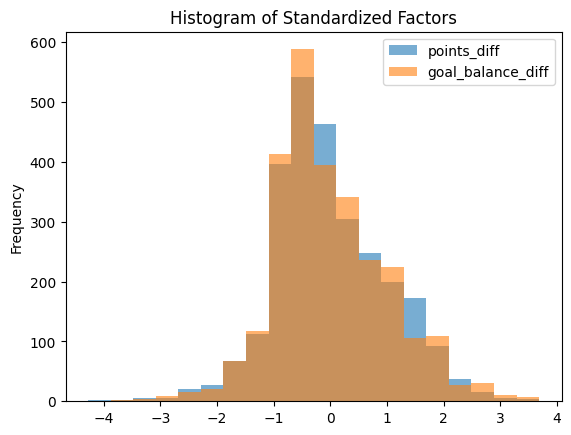

In [5]:
factors_numeric_sdz.plot(
    kind="hist", alpha=0.6, bins=20, title="Histogram of Standardized Factors"
);

Notice how both numeric factors are now centered at 0 with similar spreads. This standardization ensures they contribute comparably to the model and helps with MCMC sampling efficiency.

Now let's look at the distribution of our outcome variable—goals scored per match:

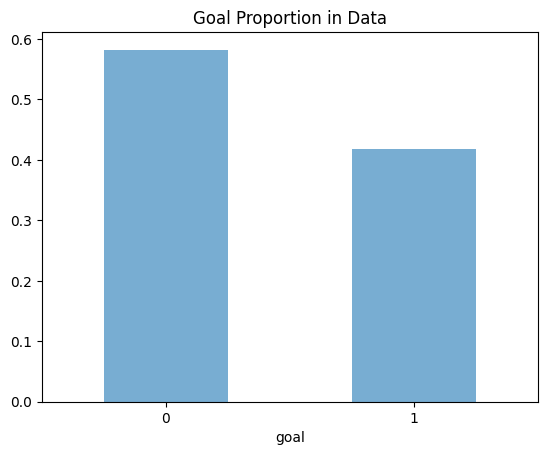

In [6]:
complete_data["goal"].value_counts(normalize=True).plot(
    alpha=0.6, kind="bar", rot=0, title="Goal Proportion in Data"
);

This shows the typical distribution we expect in soccer: most matches result in no goals for a given player (0), with a smaller proportion where they score (1). This class imbalance is natural—even elite strikers don't score in every match. Our Bernoulli likelihood will handle this appropriately.

## HSGP Parameters: Modeling Temporal Dynamics

### Why Gaussian Processes for Temporal Effects?

Player performance varies over time in complex, non-linear ways:
- **Injuries**: A player might struggle for weeks after returning from injury
- **Form**: Hot streaks and cold spells appear within a season
- **Aging**: Young players improve, peak in their prime, then gradually decline
- **Fatigue**: Performance might dip late in congested fixture schedules

We don't know the exact functional form of these effects. Should form follow a sine wave? A random walk? Something else entirely? 

**GPs let the data tell us.** Instead of imposing a rigid functional form, GPs flexibly learn smooth patterns from the data while quantifying uncertainty.

### The HSGP Approximation

We'll use the **Hilbert Space GP (HSGP)** approximation, which makes GP inference computationally tractable for larger datasets. HSGP approximates the GP using a series of basis functions—think of it as expressing a smooth curve using a sum of simple periodic functions (like Fourier series).

For more details, see:
- [HSGP paper (Riutort-Mayol et al., 2020)](https://arxiv.org/abs/2004.11408)
- [PyMC HSGP Basic Tutorial](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html)
- [PyMC HSGP Advanced Tutorial](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Advanced.html)

### Three Timescales, Three GPs

We'll fit **three separate HSGPs** to capture different temporal patterns:

1. **Short-term** (gameday-level, lengthscale ~2-5 matchdays): Quick fluctuations, noise
2. **Medium-term** (gameday-level, lengthscale ~15-25 matchdays): Within-season form (hot/cold streaks)
3. **Long-term** (season-level, lengthscale ~2-6 seasons): Aging curves (career trajectory)

By combining these, we can separate persistent career trends from temporary form fluctuations.

### Choosing HSGP Parameters: `m` and `c`

HSGP requires specifying two parameters:

- **`m`** (number of basis functions): Higher `m` → better approximation of GPs with **small lengthscales**, but higher computational cost
- **`c`** (boundary factor): Higher `c` → better approximation of GPs with **large lengthscales**, but may need more `m` to maintain fidelity

**Key considerations**:
1. Consider the **range of your input data** (e.g., matchdays 1-38, seasons 0-20)
2. Consider your **expected lengthscale range** (how quickly do you expect correlation to decay?)
3. Make sure predictions won't be affected by **boundary conditions**
4. The **first basis vector may be unidentified with the intercept** when `c` is large—we'll drop it with `drop_first=True`

Fortunately, PyMC provides `pm.gp.hsgp_approx.approx_hsgp_hyperparams()` to help us choose reasonable `m` and `c` values!

### Understanding the Data Range: Matchdays

Let's first examine the range of matchdays in our data. In soccer, a full Premier League season has 38 matchdays (each team plays 19 home and 19 away games).

This distribution tells us our gameday-scale GPs will receive inputs ranging from 1 to 38.

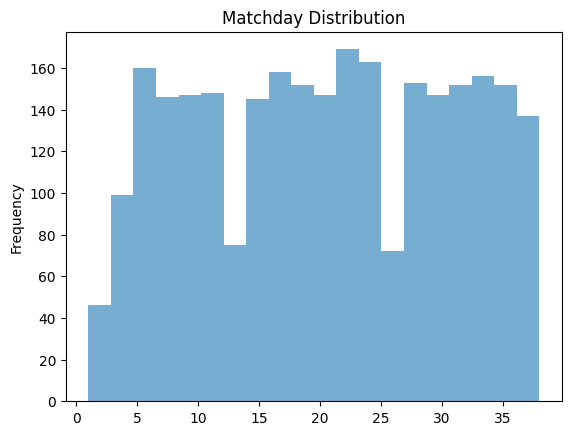

In [7]:
complete_data.matchday.plot(
    kind="hist", alpha=0.6, bins=20, title="Matchday Distribution"
);

The distribution is relatively uniform across matchdays 1-38, as expected. Each matchday has roughly equal representation in our dataset.

### Lengthscale Priors: Encoding Domain Knowledge

Before choosing `m` and `c`, we need to specify our expected **lengthscale ranges**. The lengthscale controls how quickly correlation decays—larger lengthscales mean smoother, slower-varying functions.

**Short-term GP** (2-5 matchdays): Captures rapid fluctuations and near-term effects like recent injury or a bad week of training.

**Medium-term GP** (15-25 matchdays): Captures sustained form changes—the difference between a player in a purple patch versus a goal drought lasting months.

We use **maximum entropy priors** via PreliZ to encode these ranges while remaining minimally informative otherwise. This is Bayesian best practice: we specify what we know (reasonable lengthscale bounds from domain knowledge) without imposing unnecessary constraints.

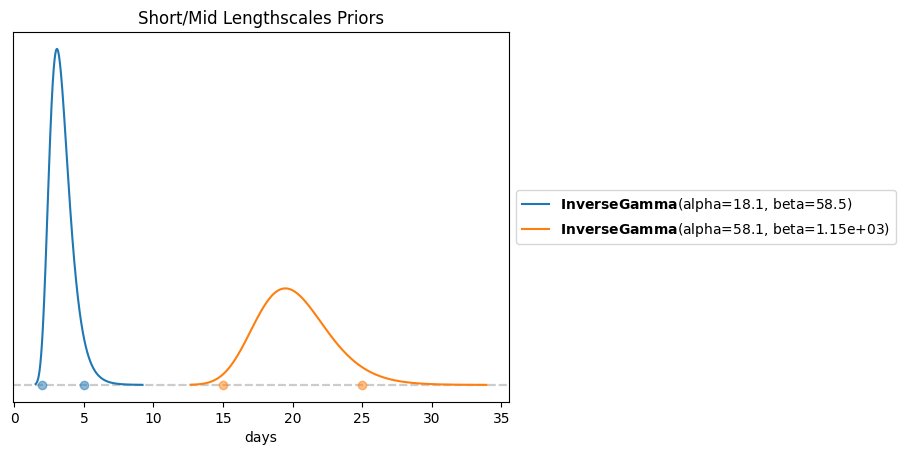

In [8]:
ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
ls_medium_dist, ax = pz.maxent(pz.InverseGamma(), 15, 25)
ax.set(title="Short/Mid Lengthscales Priors", xlabel="days");

These priors encode our belief that:
- Short-term effects decay quickly (2-5 matchdays)
- Medium-term form persists longer (15-25 matchdays, roughly half a season)

The InverseGamma distribution allows for heavy right tails, acknowledging that lengthscales could be larger than our central range suggests, but we think the specified range is most plausible.

### Choosing `m` and `c` for Within-Season GP

Now we use PyMC's helper function to choose HSGP parameters:

- **`x_range`**: The range of our input data (matchdays 0-38)
- **`lengthscale_range`**: Our expected lengthscale bounds (combining short and medium: 5-25 matchdays)
- **`cov_func`**: The covariance function we'll use (Matérn52 for smoothness)

The function recommends `m` and `c` values that will accurately approximate GPs with these characteristics.

In [9]:
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.matchday.max()],
    lengthscale_range=[5, 25],  # nbr of matchdays with autocorrelation
    cov_func="matern52",  # our covariance function
)

print("Recommended smallest number of basis vectors (m):", m_within)
print("Recommended smallest scaling factor (c):", np.round(c_within, 1))

Recommended smallest number of basis vectors (m): 54
Recommended smallest scaling factor (c): 5.4


These recommended values balance approximation accuracy with computational efficiency. With `m` around 50-60 basis functions and `c` around 5-6, we can accurately represent the smooth within-season fluctuations we expect.

Now let's examine the season distribution to inform our long-term GP:

### Understanding the Data Range: Seasons

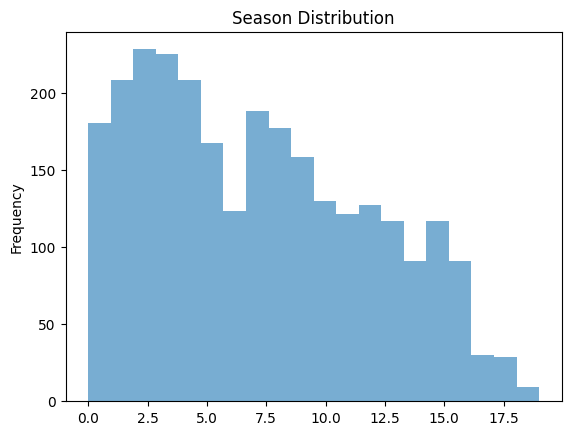

In [10]:
complete_data.season_nbr.plot(
    kind="hist", alpha=0.6, bins=20, title="Season Distribution"
);

The distribution is right-skewed: many observations from early seasons (young players), fewer from late career seasons. This is natural—only exceptional players maintain top-level performance for 15+ seasons.

### Choosing `m` and `c` for Long-Term (Aging) GP

For the long-term GP modeling career trajectories, we expect:

- **Lengthscale range**: 2-6 seasons (performance over a few years is correlated)
- **Input range**: 0 to max season number in the data

A lengthscale of 2-6 seasons makes sense: a player's performance today tells us something about their performance 2-3 years from now, but correlation weakens over longer timescales. This captures the smooth aging curves we expect—young players improving, peak years, and eventual decline.

Again, we use the helper function to get appropriate HSGP parameters.

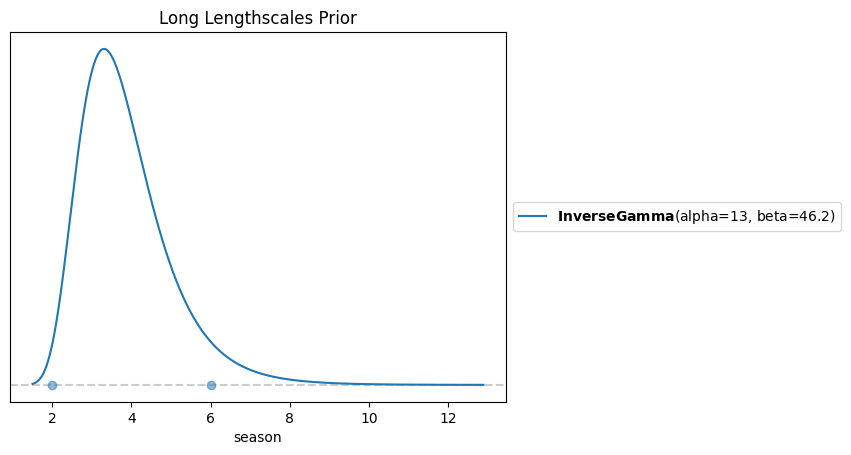

In [11]:
ls_long_dist, ax = pz.maxent(pz.InverseGamma(), 2, 6)
ax.set(title="Long Lengthscales Prior", xlabel="season");

In [12]:
m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.season_nbr.max()],
    lengthscale_range=[2, 6],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_long)
print("Recommended smallest scaling factor (c):", np.round(c_long, 1))

Recommended smallest number of basis vectors (m): 32
Recommended smallest scaling factor (c): 2.6


With these parameters chosen, we're ready to build our complete hierarchical model with GP components.

## Building the PyMC Model

Now we're ready to build our hierarchical factor model with GP components. We'll construct it step-by-step, adding one piece at a time.

First, let's set up the coordinate system and data containers that will organize our model.

### Setting Up Coordinates and Indices

PyMC uses a **coordinate system** to organize multi-dimensional parameters. This makes it easy to index and visualize results.

We create:
- **Categorical indices** for players and gamedays (mapping names/days to integer codes)
- **Coordinate dictionary** defining the dimensions our model will use

This organizational structure will make our model code cleaner and our posterior analysis much easier.

In [13]:
# Create categorical indices for players
player_idx = pd.Categorical(
    complete_data["name_player"], categories=players_ordered
).codes

# Create categorical indices for gamedays
unique_gamedays = complete_data["matchday"].sort_values().unique()
gameday_idx = pd.Categorical(
    complete_data["matchday"],
    categories=unique_gamedays,
).codes

# Get unique seasons
unique_seasons = complete_data["season_nbr"].unique()

# Define coordinate system for the model
coords = {
    "factor": factors,
    "gameday": unique_gamedays,
    "obs_id": complete_data.index,
    "player": players_ordered,
    "season": unique_seasons,
    "timescale": ["short", "medium", "long"],
}

print(f"Number of observations: {len(complete_data)}")
print(f"Number of players: {len(players_ordered)}")
print(f"Number of unique gamedays: {len(unique_gamedays)}")
print(f"Number of unique seasons: {len(unique_seasons)}")
print(f"Number of factors: {len(factors)}")

Number of observations: 2724
Number of players: 8
Number of unique gamedays: 38
Number of unique seasons: 20
Number of factors: 3


### Data Containers

We use `pm.Data()` to create containers for our observed data. This serves two purposes:

1. **In-sample**: During model fitting, these hold our training data
2. **Out-of-sample**: We can swap in new data later for predictions without rebuilding the model

All our key variables are stored here: factors, time indices (gameday, season, player), and the outcome (goals scored).

In [14]:
with pm.Model(coords=coords) as SFM_rlp:
    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data(
        "season_id", complete_data["season_nbr"].to_numpy(), dims="obs_id"
    )
    goals_obs = pm.Data("goals_obs", complete_data["goal"].to_numpy(), dims="obs_id")

### Hierarchical Player Effects

This is the core of our factor model: **player-specific skill parameters** $\alpha_i$.

We use a **hierarchical prior** (also called partial pooling):

$$\alpha_i \sim \text{Normal}(\mu_{\text{global}}, \sigma)$$

where:
- $\mu_{\text{global}}$: Population mean (logit of overall goal rate)
- $\sigma$: Player diversity (how much players vary in skill)

**Why hierarchical?** This structure:
1. **Shares information** across players (helps when data is limited for some players)
2. **Learns diversity** from the data (how much do players actually differ?)
3. **Regularizes** individual estimates (extreme values get shrunk toward the mean)

The prior on $\sigma$ (player diversity) comes from domain knowledge: we expect moderate variation in player skill, not extreme differences. The maximum entropy prior finds the unique distribution that encodes this while remaining minimally informative.

/tmp/ipykernel_251262/512122256.py:1: UserWarning: 
The requested mass is 0.94,
but the computed one is 0.811
  player_diversity_dist, ax = pz.maxent(pz.Exponential(), 0.1, 2)


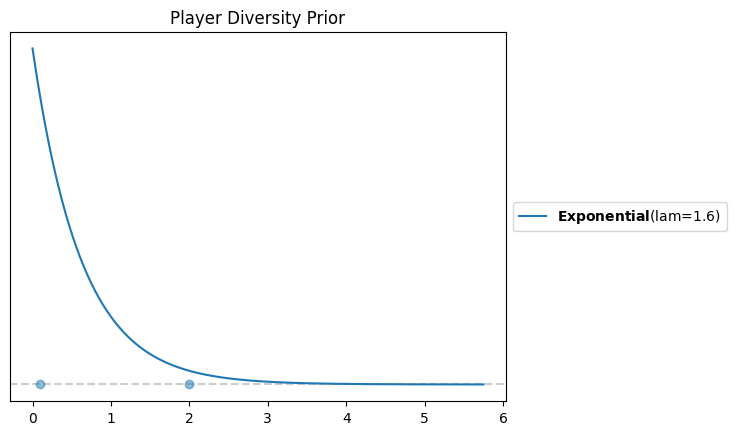

In [15]:
player_diversity_dist, ax = pz.maxent(pz.Exponential(), 0.1, 2)
ax.set(title="Player Diversity Prior");

In [16]:
with SFM_rlp:
    sigma = player_diversity_dist.to_pymc(name="player_diversity")
    player_effect = pm.Normal(
        "player_effect",
        mu=logit(complete_data["goal"].mean()),
        sigma=sigma,
        dims="player",
    )

### Defining the Gaussian Processes

This is where we build our three-timescale temporal model. Let's break down what's happening:

#### 1. GP Hyperparameters

**Amplitude** (marginal standard deviation): How much can the GP vary from 0?
- We use a **penalized complexity (PC) prior**: Exponential distribution chosen so there's only 1% probability that amplitude exceeds a threshold
- This weakly regularizes toward 0 while allowing data to push it higher if needed

> **Penalized Complexity Priors** provide a practical way to set informative priors in hierarchical models. They start from a simple base model and measure a richer model’s deviation using a Kullback-Leibler-based distance. The prior density falls exponentially with that distance, so the base model (distance = 0) remains most likely and overfitting is discouraged. You only specify a scale parameter by choosing an interpretable upper bound U and a small tail probability α, keeping the prior transparent, reparameterization-invariant, and parsimonious.


**Lengthscale**: Controls smoothness (we specified these earlier via maximum entropy priors)

#### 2. Covariance Functions

We use **Matérn52** kernels for all GPs:
- Smoother than Matérn32, rougher than squared exponential
- Good default for natural phenomena
- Differentiable (unlike Matérn12), allowing gradient-based inference

We create **composite kernels**:
- `cov_within = cov_short + cov_medium`: Combines fast and slow within-season variation
- `cov_long`: Separate kernel for across-season aging

**Kernel addition** means these components are independent and additive—within-season form and aging effects combine linearly in logit space.

#### 3. HSGP Construction

**For within-season GP**: We use `.prior()` method, which:
- Creates the HSGP approximation automatically
- Returns the GP evaluated at our gameday coordinates
- Uses `drop_first=True` to avoid aliasing with the intercept

**For long-term GP**: We use `.prior_linearized()` to demonstrate the underlying structure:
- Returns basis vectors and spectral densities explicitly
- We manually construct the GP with a **non-centered parameterization**
- This improves sampling efficiency for hierarchical models

The non-centered parameterization expresses:
$$f_{\text{long}} = \Phi \times (\beta \odot \sqrt{\text{PSD}})$$
where $\beta \sim \text{Normal}(0,1)$ are standardized coefficients, making sampling easier.

In [17]:
with SFM_rlp:
    X_gamedays = pm.Data("X_gamedays", unique_gamedays, dims="gameday")[:, None]
    X_seasons = pm.Data("X_seasons", unique_seasons, dims="season")[:, None]

    ## PC prior on amplitude
    # 1% chance that amplitude > sigmoid(1.1)=0.75%
    alpha_scale, upper_scale = 0.01, 1.1
    amplitude = pm.Exponential(
        "amplitude", lam=-np.log(alpha_scale) / upper_scale, dims="timescale"
    )
    ls = pm.InverseGamma(
        "ls",
        alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
        beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
        dims="timescale",
    )

    # cov matrices
    cov_short = amplitude[0] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
    cov_medium = amplitude[1] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
    cov_within = cov_short + cov_medium
    cov_long = amplitude[2] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])

    ## define GPs
    gp_within = pm.gp.HSGP(
        m=[m_within],
        c=c_within,
        cov_func=cov_within,
        drop_first=True,
    )
    f_within = gp_within.prior(
        "f_within",
        X=X_gamedays,
        hsgp_coeffs_dims="basis_coeffs_within",
        dims="gameday",
    )

    ## using .prior_linearized, just for demo
    gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long, drop_first=True)
    basis_vectors_long, sqrt_psd_long = gp_long.prior_linearized(X=X_seasons)
    basis_coeffs_long = pm.Normal(
        "basis_coeffs_long", shape=gp_long.n_basis_vectors - 1
    )
    # non-centered parameterization
    f_long = pm.Deterministic(
        "f_long",
        basis_vectors_long @ (basis_coeffs_long * sqrt_psd_long),
        dims="season",
    )

### Combining Skill and Temporal Effects

Now we assemble the complete linear predictor for player skill:

$$\alpha = \alpha_i[\text{player}] + f_{\text{within}}[\text{gameday}] + f_{\text{long}}[\text{season}]$$

This combines three components:
1. **Player-specific baseline** ($\alpha_i$): Persistent skill level
2. **Within-season variation** ($f_{\text{within}}$): Form fluctuations within a season
3. **Long-term trajectory** ($f_{\text{long}}$): Career aging curve

Notice we use **indexing** to broadcast these components to the observation level:
- `player_effect[player_id]`: Maps player-level parameters to each match observation
- `f_within[gameday_id]`: Maps gameday-level GP values to each observation
- `f_long[season_id]`: Maps season-level GP values to each observation

This $\alpha$ represents player skill **after** accounting for temporal dynamics but **before** accounting for team context (factors).

In [18]:
with SFM_rlp:
    alpha = pm.Deterministic(
        "alpha",
        player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
        dims="obs_id",
    )

### Adding Team Context: Factor Coefficients

The factor coefficients $\boldsymbol{\beta}$ quantify how much team context affects scoring probability.

We use a **weakly informative prior**: `Normal(0, 0.25)` on the logit scale. This says:
- We expect factors to have modest effects (centered at 0)
- But we allow data to push them higher if needed
- On the probability scale, a coefficient of ±0.25 changes odds by roughly ±28%

Since we standardized our factors, all coefficients get the same prior—they're on comparable scales.

In [19]:
with SFM_rlp:
    slope = pm.Normal("slope", sigma=0.25, dims="factor")

### Likelihood: Bernoulli Regression

Finally, we connect our model to the data through the **likelihood**:

$$p = \text{sigmoid}(\alpha + \mathbf{X} \boldsymbol{\beta})$$
$$y \sim \text{Bernoulli}(p)$$

This is **logistic regression**:
1. Combine player skill ($\alpha$) and team context ($\mathbf{X} \boldsymbol{\beta}$) linearly
2. Transform to probability via sigmoid function
3. Model binary outcomes (goal/no goal) with Bernoulli distribution

The **sigmoid** (logistic) function maps the real line to $[0,1]$:
$$\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}$$

This ensures our predicted probabilities are valid (between 0 and 1) regardless of how large or small the linear predictor becomes.

In [20]:
with SFM_rlp:
    # regression
    p = pm.Deterministic(
        "p", pm.math.sigmoid(alpha + pm.math.dot(factor_data, slope)), dims="obs_id"
    )

    # likelihood
    pm.Bernoulli(
        "goals_scored",
        p=p,
        observed=goals_obs,
        dims="obs_id",
    )

### Visualizing the Model Structure

The graphical model shows the complete dependency structure. Notice:

- **Hierarchical structure**: Player effects (squares) depend on shared diversity parameter
- **GP components**: Temporal effects with hyperparameters (amplitude, lengthscale)
- **Observed data**: The shaded `goals_scored` node
- **Deterministic nodes**: `alpha` and `p` are computed from other parameters (no additional randomness)

This visualization makes the model's assumptions explicit and helps identify potential issues before fitting.

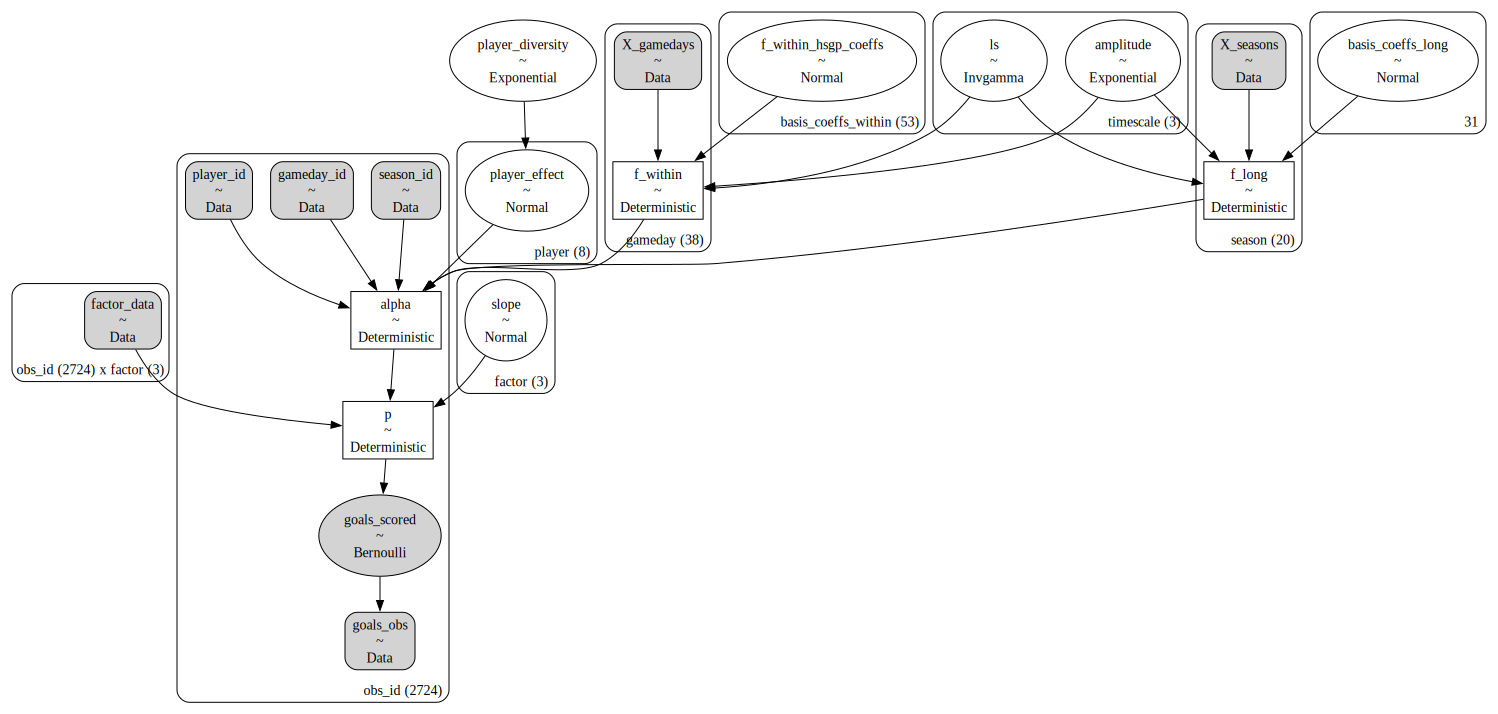

In [21]:
pm.model_to_graphviz(SFM_rlp)

## Prior Predictive Checks

Before fitting the model, we should **always** check our priors. Prior predictive sampling generates data from the model **before** seeing the actual observations. This helps us verify:

1. **Prior makes sense**: Do simulated outcomes cover reasonable ranges?
2. **No coding errors**: Does the model run without errors?
3. **Computational feasibility**: Will sampling be tractably fast?

If prior predictions are wildly unrealistic (e.g., predicting 100% scoring rates or negative probabilities), we need to revise our priors before wasting time on posterior sampling.

Let's examine three aspects of our priors: scoring probabilities, predicted goals, and GP temporal patterns.

In [22]:
with SFM_rlp:
    idata = pm.sample_prior_predictive(random_seed=rng)

Sampling: [amplitude, basis_coeffs_long, f_within_hsgp_coeffs, goals_scored, ls, player_diversity, player_effect, slope]


### Prior Scoring Probabilities

This shows the prior distribution over **scoring rates** for a single observation. 

What we want to see:
- Distribution centered somewhere reasonable (not at 0% or 100%)
- Sufficient spread to allow data to move it substantially
- No impossible values (outside [0,1])

The prior should be **weakly informative**: constraining extreme nonsense while allowing the data to dominate inference. If this distribution looks unreasonable, we'd revise our priors before proceeding.

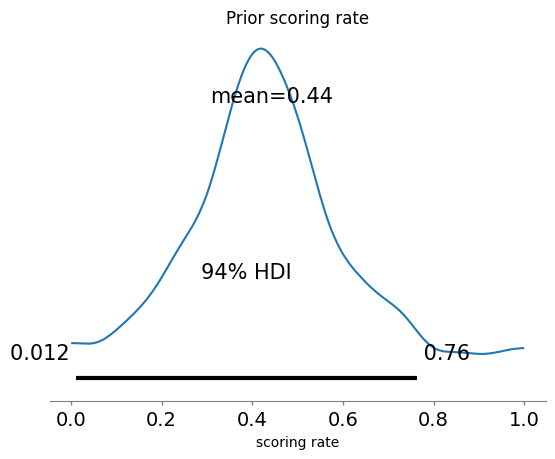

In [23]:
ax = az.plot_posterior(idata.prior.p.sel(obs_id=0))
ax.set(
    xlabel="scoring rate",
    title="Prior scoring rate",
);

### Prior Predictive Goals

This shows simulated goal outcomes (0 or 1) from our prior. Since we're modeling binary events with relatively low base rates, we expect:
- Most predictions to be 0 (no goal)
- Some predictions to be 1 (goal scored)
- Proportion matching roughly what we know about soccer (goals are infrequent events)

If the prior predicted goals in 90% of matches, we'd know something was wrong—that's not realistic for soccer. This check confirms our model structure is sensible.

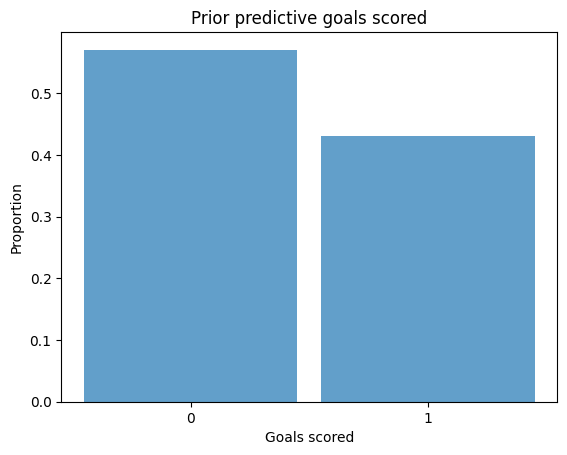

In [24]:
ax = az.plot_dist(
    idata.prior_predictive.goals_scored,
    hist_kwargs={"alpha": 0.7},
)
ax.set(
    xlabel="Goals scored", title="Prior predictive goals scored", ylabel="Proportion"
);

### Prior GP Functions

Let's prepare the data to visualize our temporal GPs. We need to align the within-season and long-term GPs on a common timeline for visualization.

In [25]:
f_within_prior = idata.prior["f_within"]
f_long_prior = idata.prior["f_long"]

index = pd.MultiIndex.from_product(
    [unique_seasons, unique_gamedays],
    names=["season_nbr", "gameday"],
)
unique_combinations = pd.DataFrame(index=index).reset_index()

f_long_prior_aligned = f_long_prior.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_prior_aligned["timestamp"] = unique_combinations.index

f_within_prior_aligned = f_within_prior.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_prior_aligned["timestamp"] = unique_combinations.index

f_total_prior = f_long_prior_aligned + f_within_prior_aligned

some_draws = rng.choice(f_total_prior.draw, size=20, replace=True)

These plots visualize what temporal patterns our GP priors allow **before seeing data**:

**Top row**: Individual GP components
- **Left (Within-season)**: Short and medium timescale variation across matchdays
- **Right (Long-term)**: Aging curves across seasons

**Bottom (Total)**: Combined effect of all temporal components

What to look for:
- **Smoothness**: Functions should be continuous, not jumpy (our Matérn52 kernel enforces this)
- **Amplitude**: Variation should be reasonable (not swinging wildly between ±100 goals)
- **Uncertainty**: Wide credible intervals (we're uncertain before seeing data)
- **Mean near 0**: GPs centered at 0 (the player effects capture the baseline)

The random draws (dark lines) show example realizations from the prior. The mean (yellow) and HDI (blue) summarize the distribution. Notice how the long-term GP is smoother (larger lengthscale) than the within-season GP (smaller lengthscale)—this matches our prior beliefs about how performance varies at different timescales.

After seeing data, these distributions will sharpen considerably, with uncertainty narrowing around the patterns the data supports.

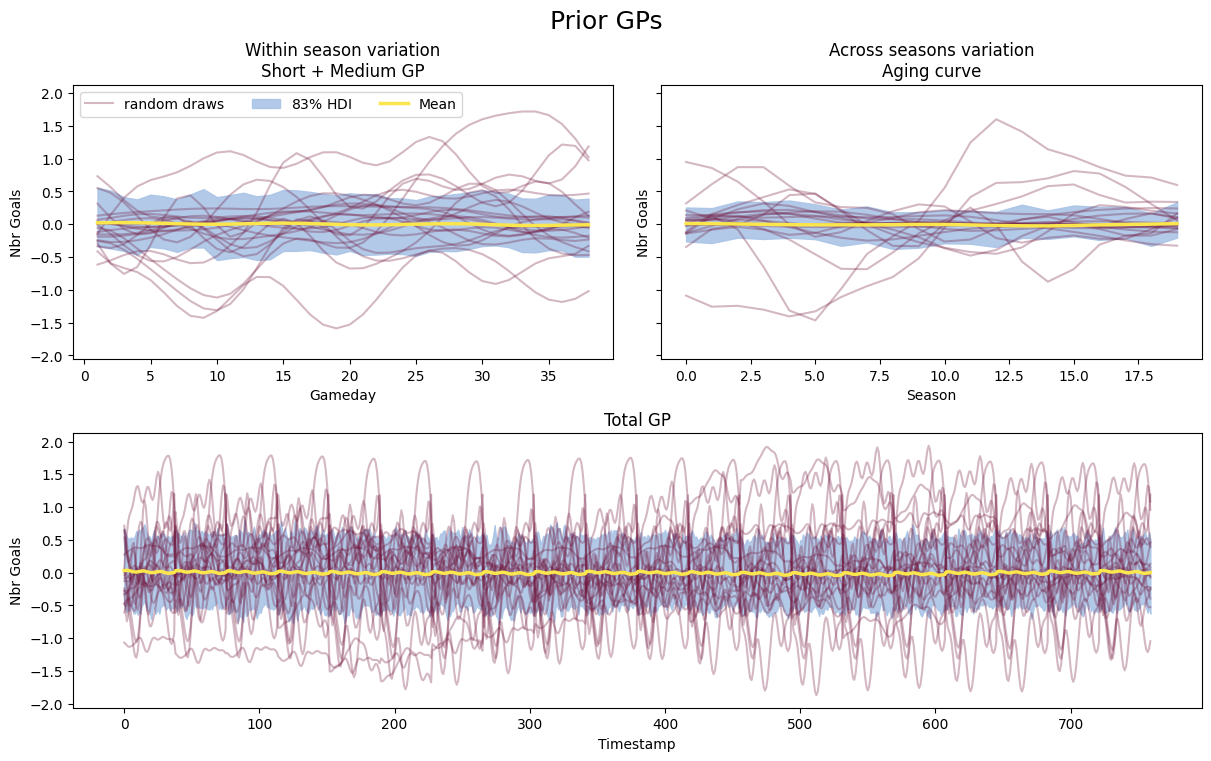

In [26]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
    sharey=True,
)

axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_prior.gameday,
    y=f_within_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_prior.gameday,
    f_within_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort + Medium GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_prior.season,
    az.extract(f_long_prior)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_prior.season,
    y=f_long_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_prior.season,
    f_long_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_prior.timestamp,
    az.extract(f_total_prior)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_prior.timestamp,
    y=f_total_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_prior.timestamp,
    f_total_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Prior GPs", fontsize=18);

## Posterior Inference

Now we fit the model using MCMC (Markov Chain Monte Carlo) sampling. We use:

- **NumPyro's NUTS sampler**: Fast, efficient implementation of the No-U-Turn Sampler
- **`target_accept=0.95`**: High acceptance rate for better exploration (at cost of slightly slower sampling)
- **Posterior predictive sampling**: Generate predictions for model checking

The sampling process:
1. **Warmup/tuning**: Algorithm adapts step size and mass matrix
2. **Sampling**: Draw from the posterior distribution
3. **Posterior predictive**: Generate predictions from the fitted model

If we see divergences or other warnings, we'd need to investigate (reparameterize, adjust priors, etc.). A few divergences (2 here) is often acceptable, but many would indicate problems.

In [28]:
with SFM_rlp:
    idata.extend(pm.sample(nuts_sampler="nutpie", random_seed=rng, target_accept=0.95))
    idata.extend(
        pm.sample_posterior_predictive(
            idata, random_seed=rng, compile_kwargs={"mode": "NUMBA"}
        )
    )

/var/home/fonnesbeck/repos/instats_gp/.pixi/envs/default/lib/python3.13/site-packages/nutpie/compile_pymc.py:891: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', True, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  return inner(x, *_shared_tuple)


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.18,31
,2000,0,0.16,31
,2000,0,0.17,31
,2000,0,0.18,31


Sampling: [goals_scored]


Output()

### Convergence Diagnostics: Effective Sample Size

**Effective Sample Size (ESS)** measures how many independent samples our MCMC chains are equivalent to, accounting for autocorrelation.

What we want:
- **ESS > 400** (bare minimum for stable estimates)
- **ESS > 1000** (good for most purposes)
- **Higher is better** (more independent information)

This table shows ESS quantiles across all parameters:
- **bulk ESS**: For central posterior estimates (mean, median)
- **tail ESS**: For extreme quantiles (important for intervals)

If ESS is very low (< 100), we'd need to run longer chains or reparameterize the model. The color coding (green = good, red = problematic) makes it easy to spot issues at a glance.

In [30]:
ess = az.ess(idata.posterior)
ess.quantile([0.01, 0.5, 0.99]).to_dataframe().astype(int).style.background_gradient(
    axis=None, cmap="RdYlGn"
)

,player_diversity_log__,player_effect,amplitude_log__,ls_log__,f_within_hsgp_coeffs,basis_coeffs_long,slope,player_diversity,amplitude,ls,f_within,f_long,alpha,p
quantile,,,,,,,,,,,,,,
0.010000,4947,2021,1983,4611,5004,3179,2292,4947,1983,4611,2846,2961,3662,3566
0.500000,4947,2546,2363,9356,9508,8707,2385,4947,2363,9356,3025,3256,5478,5290
0.990000,4947,4683,3036,9643,11422,10908,5752,4947,3036,9643,4906,5811,7216,7032


### Energy Plot: MCMC Efficiency Check

The **energy plot** compares the marginal energy distribution with the energy transition distribution. This diagnostic reveals:

**What we want to see**:
- **Overlapping distributions** (like we have here)
- **Similar shapes** between marginal and transition

**Red flags**:
- **Separated distributions**: Indicates sampler is struggling to explore efficiently
- Often caused by difficult geometry (highly correlated parameters, funnel shapes, etc.)

Our energy plot looks good—the distributions overlap well, suggesting NUTS is efficiently exploring the posterior. Combined with our low divergence count, this indicates the sampling was successful.

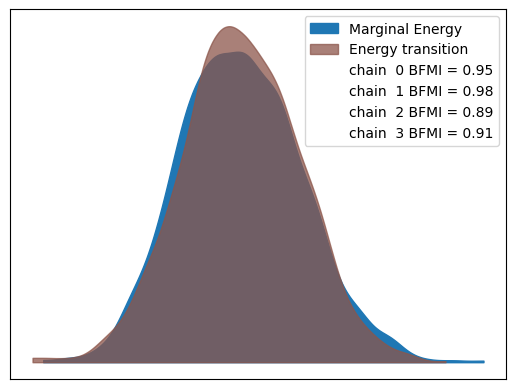

In [31]:
az.plot_energy(idata);

## Interpreting Posterior Parameters

Now we examine what the model learned from the data. We'll look at:
1. **Factor effects**: How much do team context variables matter?
2. **Player skills**: Who are the truly elite scorers after controlling for context?
3. **Temporal patterns**: How does performance vary within and across seasons?

All comparisons show **prior vs. posterior**—how much did the data update our beliefs?

### Factor Coefficients (Team Context Effects)

These forest plots show **how much team context matters** for scoring probability.

**Interpreting the coefficients**:
- **Positive values**: Factor increases scoring probability
- **Negative values**: Factor decreases scoring probability  
- **Magnitude**: Larger absolute values = stronger effects
- **Uncertainty**: Wider intervals = less certain about the effect

**What we learn**:
- Compare prior (wide, centered at 0) to posterior (narrower, shifted)
- If posterior is clearly away from 0, that factor matters
- If posterior overlaps 0 heavily, that factor might not be important

The right panel zooms in on the posterior alone for easier interpretation. Notice how the data has dramatically updated our beliefs—the posterior intervals are much narrower than the prior.

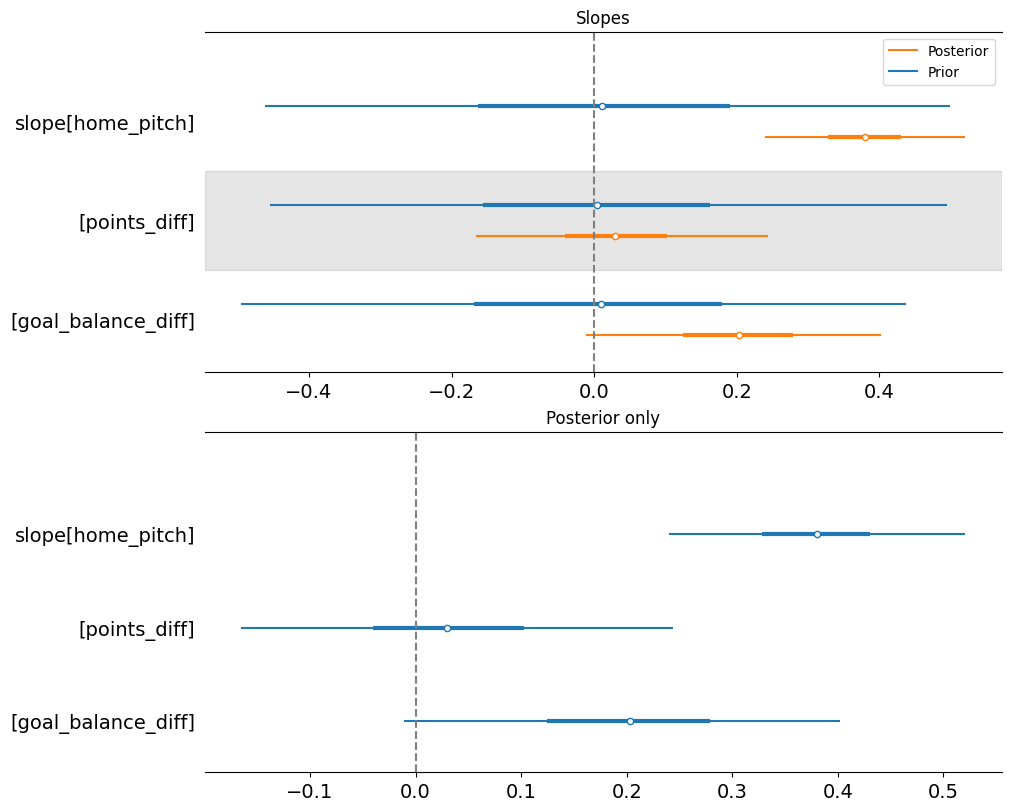

In [42]:
_, axes = plt.subplot_mosaic(
    """
    A
    B
    """,
    figsize=(10, 8),
    layout="constrained",
)

az.plot_forest(
    [idata.prior, idata.posterior],
    model_names=["Prior", "Posterior"],
    var_names=["slope"],
    combined=True,
    ax=axes["A"],
)
axes["A"].axvline(c="grey", ls="--")
axes["A"].set(title="Slopes")

az.plot_forest(
    idata,
    var_names=["slope"],
    combined=True,
    ax=axes["B"],
)
axes["B"].axvline(c="grey", ls="--")
axes["B"].set(title="Posterior only");

### Player Effects: Who Has True Skill?

This is the core output of our factor model: **player-specific skill** ($\alpha_i$) after controlling for team context and temporal dynamics.

**Interpreting player effects**:
- **Higher values**: Better scorers (all else equal)
- **Separation**: If credible intervals don't overlap, we're confident one player is better
- **Shrinkage**: The hierarchical prior pulls extreme estimates toward the population mean (dashed line)
- **Uncertainty**: Wider intervals for players with less data

**What makes this compelling**:
- We've controlled for home advantage, team quality, opponent strength, etc.
- We've separated persistent skill from temporary form and aging
- These are **skill estimates**, not just raw goal counts

Compare the prior (all players look similar) to the posterior (clear differentiation). The posterior reveals a hierarchy of talent that the prior didn't assume—this came from the data.

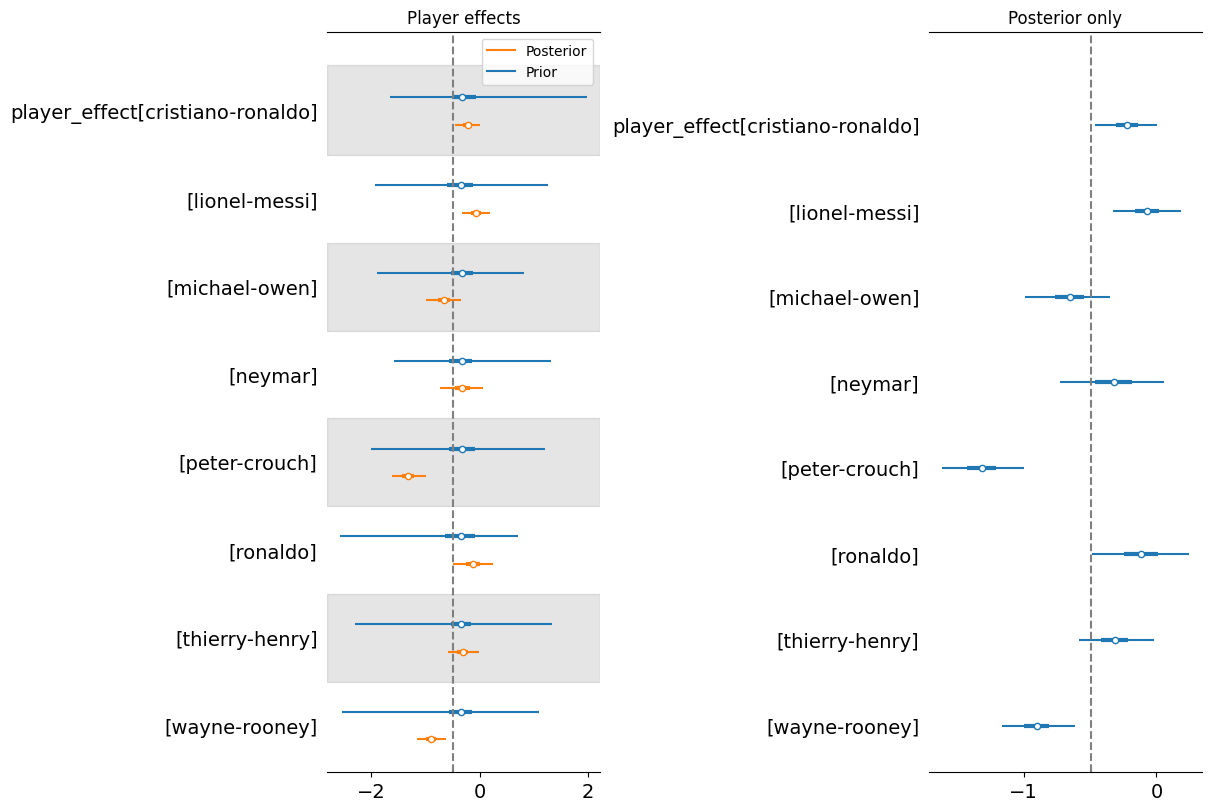

In [33]:
_, axes = plt.subplot_mosaic(
    """
    AB
    """,
    figsize=(12, 8),
    layout="constrained",
)

players_mean = idata.posterior.player_effect.mean()
az.plot_forest(
    [idata.prior, idata.posterior],
    model_names=["Prior", "Posterior"],
    var_names="player_effect",
    combined=True,
    ax=axes["A"],
)
axes["A"].axvline(x=players_mean, c="grey", ls="--")
axes["A"].set(title="Player effects")

az.plot_forest(
    idata,
    var_names="player_effect",
    combined=True,
    ax=axes["B"],
)
axes["B"].axvline(x=players_mean, c="grey", ls="--")
axes["B"].set(title="Posterior only");

## Posterior Predictive Checks

After fitting, we need to verify the model **describes the data well**. Posterior predictive checks compare:
- **Observed data**: What actually happened
- **Posterior predictions**: What the fitted model predicts

**What we want**:
- Predicted distribution overlaps observed data
- Model captures key features of the data
- No systematic discrepancies

If predictions systematically miss the data (e.g., always overpredicting), we'd need to revise the model structure.

### Prior vs. Posterior Updating: Scoring Rates

This plot shows how our beliefs about scoring rates changed after seeing the data:

- **Prior** (blue): Before seeing data, wide range of plausible scoring rates
- **Posterior** (orange): After seeing data, a narrower distribution

**What this tells us**:
1. **Learning occurred**: The posterior is more concentrated than the prior
2. **Data dominated**: The posterior location is driven by actual scoring rates, not our prior
3. **Uncertainty reduced**: We're more confident about typical scoring rates after seeing data

This is Bayesian updating in action—starting with weak beliefs, then letting data refine them.

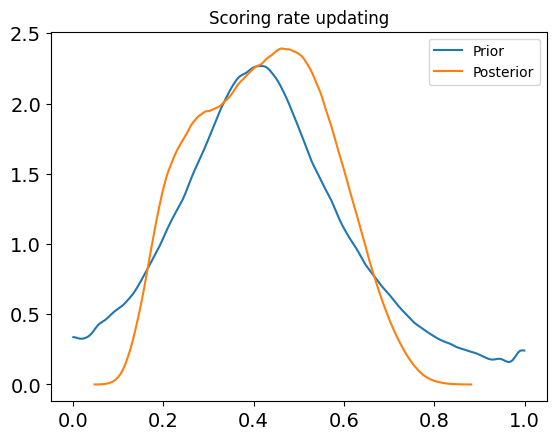

In [34]:
ax = az.plot_dist(idata.prior.p, label="Prior")
az.plot_dist(idata.posterior.p, ax=ax, color="C1", label="Posterior")
ax.set(title="Scoring rate updating");

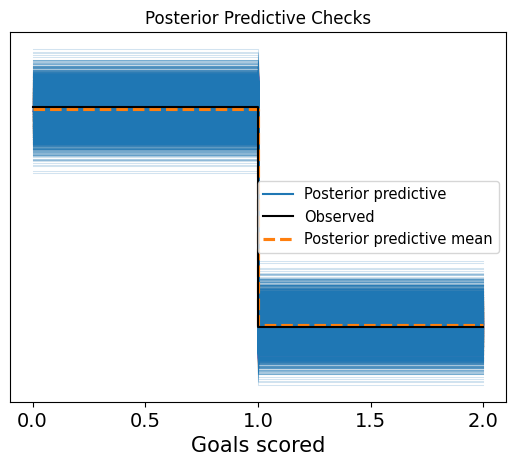

In [35]:
ax = az.plot_ppc(idata)
ax.set(xlabel="Goals scored", title="Posterior Predictive Checks");

## Temporal Dynamics: Performance Evolution

Now we examine what the GPs learned about temporal patterns. These are the **most interesting outputs** for understanding player careers:

- **Within-season**: How does form fluctuate during a season?
- **Across-season**: What do aging curves look like?
- **Combined**: The total temporal effect on scoring

Remember: These patterns are **after controlling for** player-specific baselines and team context. They capture pure temporal variation.

In [36]:
f_long_post = idata.posterior["f_long"]
f_within_post = idata.posterior["f_within"]

f_long_post_aligned = f_long_post.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_post_aligned["timestamp"] = unique_combinations.index

f_within_post_aligned = f_within_post.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_post_aligned["timestamp"] = unique_combinations.index

f_total_post = f_long_post_aligned + f_within_post_aligned

some_draws = rng.choice(4000, size=20, replace=True)

### Posterior GP Functions: What Did We Learn?

Compare these posterior GPs to the prior GPs we saw earlier:

**Within-season variation** (top left):
- **Much narrower uncertainty**: Data strongly constrains the pattern
- **Learned structure**: Notice any systematic trends? (e.g., performance dip in late season)
- **Form fluctuations**: Deviation from 0 shows matchday-to-matchday changes

**Aging curves** (top right):
- **Career trajectory**: How performance evolves across seasons
- **Peak identification**: Where is the maximum? When do players peak?
- **Decline phase**: Do we see late-career decline?

**Total temporal effect** (bottom):
- **Combined dynamics**: All temporal variation in one view
- **Magnitude**: How big are these effects compared to player baselines?

**Key insight**: The posterior uncertainty (HDI) is **much narrower** than the prior. The data has told us a great deal about temporal patterns. The smooth curves reflect our Matérn52 kernel—we get continuous, plausible performance trajectories rather than jumpy, unrealistic patterns.

This is the power of GPs: we didn't specify "performance follows a parabola" or "form varies sinusoidally"—we let the data discover the functional form while respecting smoothness constraints.

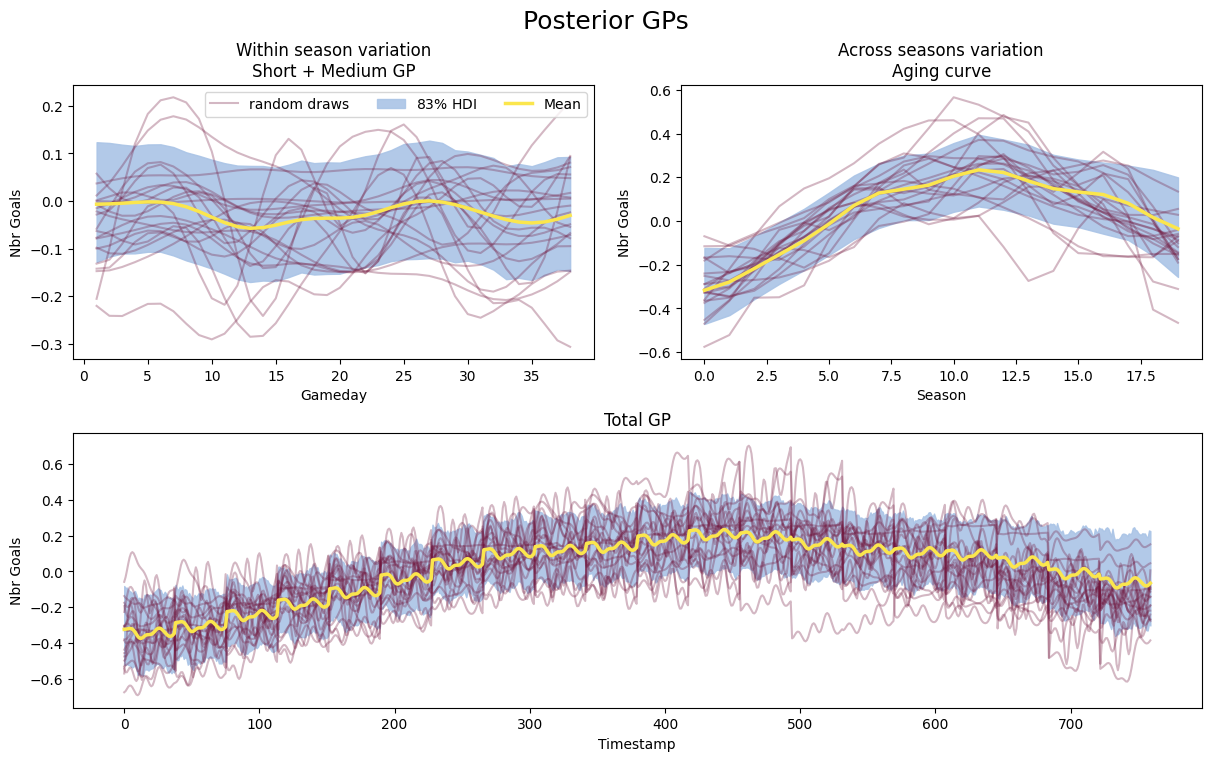

In [37]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort + Medium GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Posterior GPs", fontsize=18);

## Summary: Soccer Player Skill Modeling

This case study demonstrated how to integrate multiple advanced GP techniques into a complete hierarchical model for sports analytics:

### The Factor Model Approach

We decomposed observed goal-scoring into interpretable components:

$$P(\text{goal}_{ij} = 1) = \text{logit}^{-1}(\alpha_i + f_{\text{within}}(t) + f_{\text{long}}(s) + \mathbf{X}_{ij}^T\boldsymbol{\beta})$$

- **$\alpha_i$**: Player-specific skill (hierarchical, partial pooling)
- **$f_{\text{within}}(t)$**: Within-season form (matchday-to-matchday via HSGP)
- **$f_{\text{long}}(s)$**: Long-term aging curve (across seasons via HSGP)
- **$\mathbf{X}_{ij}^T\boldsymbol{\beta}$**: Context factors (home advantage, momentum, opponent strength)

### Technical Integration

**Hierarchical structure**: Partial pooling via `pm.Normal` with learned `sigma` balances individual variation with population patterns

**Multi-scale temporal GPs**:
- Short-term (matchday): Matérn52 kernel with lengthscale ~5-25 days
- Long-term (seasons): Matérn52 kernel with lengthscale ~2-6 seasons
- Implemented with HSGP for computational scalability

**Non-Gaussian likelihood**: Bernoulli distribution for binary outcomes (goal/no goal)

**Maximum entropy priors**: Used PreliZ to encode domain knowledge (lengthscale bounds) while remaining minimally informative

### What This Enables

1. **Skill vs. context separation**: Identify truly skilled players after controlling for confounders
2. **Temporal dynamics**: Track within-season form fluctuations and across-season development/decline
3. **Uncertainty quantification**: Full posterior distributions over all parameters
4. **Interpretability**: Each model component has clear meaning in the domain

### The GP Toolkit Mastered (Sessions 1-4)

1. **Foundations** (Session 1): MVN → GP, kernels as covariance functions, marginal vs. latent
2. **Composition** (Session 2): Kernel addition/multiplication, non-Gaussian likelihoods
3. **Scaling** (Session 3): Computational bottlenecks, sparse approximations, HSGP
4. **Integration** (Sessions 4A-4B): Multi-output models, hierarchical structure, temporal dynamics

You're now equipped to apply Gaussian processes to complex real-world problems!